This notebook explores the instability in the filter.
I use an exact (spectral) discrete Laplacian on a 1D periodic domain with 256 points.
The filter is not generated from the code; instead, I just set it up by specifying the roots `s[i]`.
I'll show a range of results before getting to the point.

In [1]:
import numpy as np
from scipy import fft
import matplotlib.pyplot as plt

The block below sets up wavenumbers `k`, the Laplacian in Fourier space `L`, and the data that I will apply the filter to `f0`. 

The data is constructed so that the DFT of the data is 1 for all wavenumbers. Once we've applied the filter, if we compute and plot the absolute value of the FFT of `f` then what we see is the effective filter shape.

In [4]:
%matplotlib inline
k = np.concatenate([np.arange(0,129), np.arange(-127,0)])
L = - k**2
fHat = np.exp(1j*np.random.standard_normal(256))
f0 = fft.ifft(fHat)

First show that the problem does not depend on `n_steps` by setting up a filter with a large number of steps that has no problem.

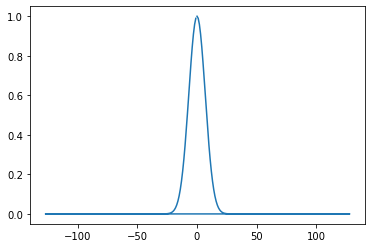

In [18]:
n_steps = 128
s = (np.arange(64,n_steps+64))**2
f = f0
for i in range(n_steps):
    fHat = fft.fft(f)
    f = fft.ifft(fHat + (1/s[i])*L*fHat)

plt.plot(k,np.abs(fft.fft(f)))

Next show that the problem begins to arise as you include more small values of `s[i]`. The plot below shows we're still OK at min `s[i]` = 54

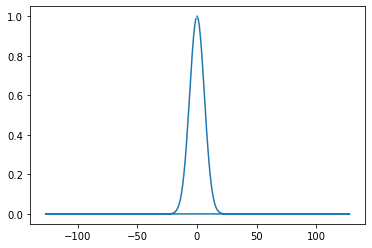

In [20]:
n_steps = 128
s = (np.arange(54,n_steps+54))**2
f = f0
for i in range(n_steps):
    fHat = fft.fft(f)
    f = fft.ifft(fHat + (1/s[i])*L*fHat)

plt.plot(k,np.abs(fft.fft(f)))

The plot below shows we have instability at min `s[i]=44`.

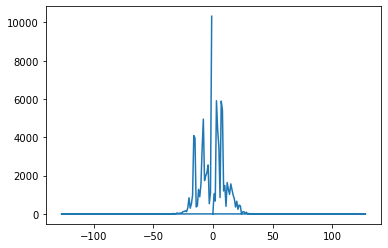

In [21]:
n_steps = 128
s = (np.arange(44,n_steps+44))**2
f = f0
for i in range(n_steps):
    fHat = fft.fft(f)
    f = fft.ifft(fHat + (1/s[i])*L*fHat)

plt.plot(k,np.abs(fft.fft(f)))

In the plot above there's no problem at small scales, but the large scales are wrong. The plot below shows that if you reverse the order of the roots `s[i]` then it still blows up, but now at the small scales:

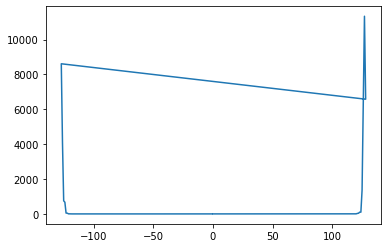

In [22]:
n_steps = 128
s = -np.sort(-(np.arange(44,n_steps+44))**2)
f = f0
for i in range(n_steps):
    fHat = fft.fft(f)
    f = fft.ifft(fHat + (1/s[i])*L*fHat)

plt.plot(k,np.abs(fft.fft(f)))

The sequence of figures below shows how the solution evolves through the internal steps of the filter. When the roots are sorted in descending order we see good behavior until right at the end.

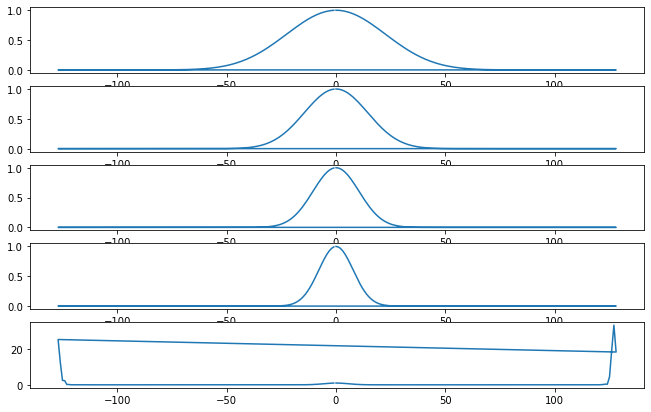

In [28]:
s = -np.sort(-(np.arange(44,n_steps+44))**2)
fig, axarr = plt.subplots(ncols=1, nrows=5, figsize=[11, 7])
for j in range(1,6):
    f = f0
    for i in range(25*j):
        fHat = fft.fft(f)
        f = fft.ifft(fHat + (1/s[i])*L*fHat)
    axarr[j-1].plot(k,np.abs(fft.fft(f)))

The plot below also shows the evolution of the solution through the internal filter stages, with the roots sorted ascending. It blows up extremely quickly, starting at the small scales.

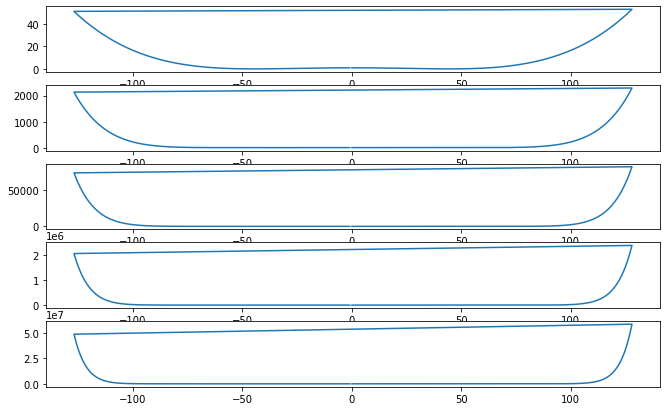

In [29]:
s = (np.arange(44,n_steps+44))**2
fig, axarr = plt.subplots(ncols=1, nrows=5, figsize=[11, 7])
for j in range(1,6):
    f = f0
    for i in range(2*j):
        fHat = fft.fft(f)
        f = fft.ifft(fHat + (1/s[i])*L*fHat)
    axarr[j-1].plot(k,np.abs(fft.fft(f)))

At each stage we multiply in Fourier space by $(1-k^2/s_i)$. If $s_i$ is small then this will amplify small scales. Conversely, for large $s_i$ we are damping small scales. We can test whether any individual filter stage will amplify scales that are present in the solution as follows. If 

$$\left|1 - \frac{k_{\text{max}}^2}{s_i}\right|\le 1$$

then there is no amplification, otherwise there is amplification.

The problem with the above filter is that the first several stages all amplify the small scales to the point where by the time the damping stages begin we've already started to lose numerical precision.
(When the roots are reversed, the small scales are immediately damped almost to zero, but not quite because of roundoff. When the later stages arrive they amplify any roundoff present at small scales.)

This suggests that we can postpone the instability by interleaving steps that amplify the small scales and steps that damp them. The following code bears this out.

I start by sorting the roots from most-damping to most-amplifying. Then I split the list of roots into two lists: one damping and one amplifying.
Then I interleave the two lists (using some code from [here](https://stackoverflow.com/questions/48199961/how-to-interleave-two-lists-of-different-length/48200036)) so that the most-damping stage is first, then the most-amplifying, etc.

In [59]:
from itertools import chain, zip_longest
def twolists(l1, l2):
    return [x for x in chain(*zip_longest(l1, l2)) if x is not None]

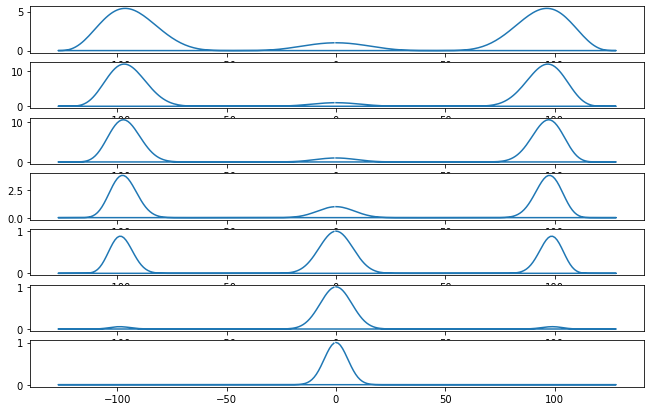

In [78]:
s = (np.arange(44,n_steps+44))**2
ind = np.argsort(np.abs(1 - 128**2/s))
s = s[ind] # sorted from most damping to most amplifying
indD = np.argwhere(np.abs(1 - 128**2/s)<=1)
indA = np.argwhere(np.abs(1 - 128**2/s)>1)
sD = s[indD].tolist() # Damping roots, sorted most to least damping
sA = np.flip(s[indA]).tolist() # Amplifying roots, sorted most to least amplifying
s = twolists(sD,sA)
s = np.array([y for x in s for y in x])
fig, axarr = plt.subplots(ncols=1, nrows=7, figsize=[11, 7])
for j in range(1,7):
    f = f0
    for i in range(8*j):
        fHat = fft.fft(f)
        f = fft.ifft(fHat + (1/s[i])*L*fHat)
    axarr[j-1].plot(k,np.abs(fft.fft(f)))

f = f0
for i in range(n_steps):
    fHat = fft.fft(f)
    f = fft.ifft(fHat + (1/s[i])*L*fHat)
axarr[6].plot(k,np.abs(fft.fft(f)))

The plot above shows the internal stages of the filter. The first plot (after 8 stages) shows some amplification at intermediate scales, but it doesn't get out of hand. The next few plots show similar behavior: there is some amplification at intermediate scales, but it doesn't get out of hand. By the penultimate plot (after 48 stages) the amplification at intermediate scales is dying away, and the remainder of the stages (not shown) are pretty boring.

This notebook only deals with Laplacian stages. A single biharmonic stage is equivalent to multiplying by 

$$\left|1 - \frac{k_{\text{max}}^2}{s_i}\right|^2$$

in Fourier space, where $s_i$ is the complex root. I think we could deal with biharmonic stages in the same way.
First separate the real and complex roots, and only keep one of each complex pair.
Then, for the pruned list of roots evaluate

$$\left|1 - \frac{k_{\text{max}}^2}{s_i}\right|$$

where now the absolute value is of a complex number.
Separate into two lists: one list of roots that damp small scales and the other list that amplifies small scales.
Then make sure the lists are ordered most-damping to least-damping and most-amplifying to least-amplifying, and then merge/interleave the lists as above.

The code would need to output just one list of roots and a modified `n_steps` (the length of the final, pruned and sorted list).
The code to _apply_ the filter would also have to be changed to a single loop, and then at each cycle in the loop you test whether `s[i]` is real, which implies a Laplacian step, or complex, which implies a biharmonic step.